# Demo: Training GPT-2 with TensorFlow and Keras

This notebook demonstrate training a GPT-2 model from scratch with TensorFlow and Keras. We will will train the model on a text dataset and make it generate similar texts.


Note that training GPT-2 models can be computationally expensive, and using a GPU is highly recommended.

**References**:
- [nanoGPT](https://github.com/karpathy/nanoGPT)
- [Text generation with a miniature GPT](https://keras.io/examples/generative/text_generation_with_miniature_gpt/)

## Set Up Environment

### Install required packages

In [1]:
!pip install tensorflow==2.16.1 keras==3.1.1 keras-nlp==0.8.2

### Download dataset

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4780k      0  0:00:17  0:00:17 --:--:-- 7127k


## Import and Define Global Constants

In [3]:
import math
import os
import random
import string

import keras
import keras_nlp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import ops
from keras.layers import (Dense, Dropout, Embedding, Input, Layer, LayerNormalization,
                          MultiHeadAttention, TextVectorization)
from matplotlib import pyplot as plt

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [4]:
IS_TRAIN = True
MIXED_PRECISION = False     # Use mixed precision for training.
DETERMINISM = True          # Run in deterministic mode.
FREEZE_BACKBONE = False
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
VOCABULARY_SIZE = 20000
BATCH_SIZE = 128
MAX_SEQ_LENGTH = 80
EMBEDDING_DIM = 256
NUM_LAYERS = 1
NUM_ATTENTION_HEADS = 2
TRAIN_EPOCHS = 10
LEARNING_RATE = 1e-3

In [5]:
if MIXED_PRECISION:
    keras.mixed_precision.set_global_policy('mixed_float16')

if DETERMINISM:
    keras.utils.set_random_seed(SEED)

## Prepare Data

In this demo, we will use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/). The dataset is originally for binary sentiment classification that has a set of 25,000 movie reviews for training, and 25,000 for testing. Besides, the dataset contains each review in a separate text file.


In [6]:
def custom_standardization(input_string):
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, f'([{string.punctuation}])', r' \1')


def prepare_lm_inputs_labels(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    inputs = tokenized_sentences[:, :-1]
    labels = tokenized_sentences[:, 1:]
    return inputs, labels


def create_dataset(file_paths, is_training=False):
    dataset = tf.data.TextLineDataset(sorted(file_paths))
    dataset = dataset.batch(BATCH_SIZE)

    if is_training:
        vectorize_layer.adapt(dataset)
        dataset = dataset.shuffle(buffer_size=256, seed=SEED)

    dataset = dataset.map(prepare_lm_inputs_labels,
                          num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [7]:
file_paths = []
data_directories = [
    'aclImdb/train/pos',
    'aclImdb/train/neg',
    'aclImdb/test/pos',
    'aclImdb/test/neg',
]

for directory in data_directories:
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        file_paths.append(file_path)

random.shuffle(file_paths)
train_set_size = int(len(file_paths) * 0.9)
train_file_paths = file_paths[:train_set_size]
val_file_paths = file_paths[train_set_size:]

print(f'{len(train_file_paths)} train files, {len(val_file_paths)} validation files')

# Create the text vectorization layer.
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LENGTH + 1,
    pad_to_max_tokens=True
)

# Create training and validation datasets.
train_ds = create_dataset(train_file_paths, is_training=True)
val_ds = create_dataset(val_file_paths)

45000 train files, 5000 validation files


In [8]:
print('Show samples in the train dataset:')
for i, (data_batch, label_batch) in enumerate(train_ds.take(2)):
    print(f'Sample #{i + 1}')
    print(f'    text: {data_batch.numpy()}')
    print(f'    label: {label_batch.numpy()}')

Show samples in the train dataset:
Sample #1
    text: [[  12   71  444 ...    3   62   16]
 [  12  529   10 ... 3298   41   12]
 [  98   25  710 ... 4443 4130    6]
 ...
 [  17  292   41 ... 1471   63    8]
 [  12   95  221 ...  142   11    2]
 [  12  213   32 ...  142    9    5]]
    label: [[  71  444   13 ...   62   16    5]
 [ 529   10    5 ...   41   12   16]
 [  25  710   58 ... 4130    6 2576]
 ...
 [ 292   41  343 ...   63    8    4]
 [  95  221  234 ...   11    2 1219]
 [ 213   32  118 ...    9    5  541]]
Sample #2
    text: [[  79   99   26 ...    7  159    6]
 [  20    5   22 ... 4205 2708   25]
 [  13   18    4 ...   76 5528    4]
 ...
 [  13   22    9 ...  149  162   26]
 [2058   13  272 ... 5659    4    6]
 [  12  202 2075 ... 1284   50   39]]
    label: [[   99    26   535 ...   159     6    32]
 [    5    22  1272 ...  2708    25  6206]
 [   18     4    17 ...  5528     4     6]
 ...
 [   22     9   194 ...   162    26    13]
 [   13   272    42 ...     4     6  2893]

## Define Model

In [9]:
def gpt_2_kernel_initializer(stddev=0.02):
    return keras.initializers.RandomNormal(stddev=stddev)


def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = ops.arange(n_dest)[:, None]
    j = ops.arange(n_src)
    m = i >= j - n_src + n_dest
    mask = ops.cast(m, dtype)
    mask = ops.reshape(mask, [1, n_dest, n_src])
    mult = ops.concatenate(
        [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])], 0
    )
    return ops.tile(mask, mult)


class MLP(Layer):
    def __init__(self, hidden_dim, intermediate_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = Dense(
            intermediate_dim,
            use_bias=False,
            kernel_initializer=gpt_2_kernel_initializer()
        )
        self.dense_2 = Dense(
            hidden_dim,
            use_bias=False,
            kernel_initializer=gpt_2_kernel_initializer(
                0.02 / math.sqrt(2 * 1))
        )
        self.dropout = Dropout(dropout)

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = keras.activations.gelu(x, approximate=True)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class TransformerBlock(Layer):
    def __init__(
        self,
        hidden_dim,
        intermediate_dim,
        num_heads,
        dropout=0.1,
        layer_norm_epsilon=1e-05,
        **kwargs
    ):

        super().__init__(**kwargs)
        self.att = MultiHeadAttention(
            num_heads,
            hidden_dim,
            dropout=dropout,
            use_bias=False,
            kernel_initializer=gpt_2_kernel_initializer()
        )
        self.mlp = MLP(
            hidden_dim=hidden_dim,
            intermediate_dim=intermediate_dim,
            dropout=dropout
        )
        self.layernorm_1 = LayerNormalization(epsilon=layer_norm_epsilon)
        self.layernorm_2 = LayerNormalization(epsilon=layer_norm_epsilon)

    def call(self, inputs):
        batch_size, seq_len = ops.shape(inputs)[:2]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, 'bool')
        pre_norm = self.layernorm_1(inputs)
        attention_output = self.att(
            pre_norm, pre_norm, attention_mask=causal_mask)
        mid_out = inputs + attention_output
        post_norm = self.layernorm_2(mid_out)
        return mid_out + self.mlp(post_norm)


class GPT2Model(keras.Model):
    def __init__(self, config):
        super().__init__()

        self.token_emb = Embedding(
            input_dim=config.vocab_size,
            output_dim=config.n_embd,
            embeddings_initializer=gpt_2_kernel_initializer(),
            name='token_embedding'
        )
        self.pos_emb = Embedding(
            input_dim=config.n_positions,
            output_dim=config.n_embd,
            embeddings_initializer=gpt_2_kernel_initializer(),
            name='position_embedding'
        )
        self.dropout = Dropout(config.embd_pdrop)
        self.transformer_layers = [
            TransformerBlock(
                hidden_dim=config.n_embd,
                intermediate_dim=config.n_embd * 4,
                num_heads=config.n_head,
                dropout=config.resid_pdrop,
                layer_norm_epsilon=config.layer_norm_epsilon,
                name=f'transformer_layer_{i}'
            ) for i in range(config.n_layer)
        ]
        self.layer_norm = LayerNormalization(
            axis=-1,
            epsilon=config.layer_norm_epsilon,
            name='layer_norm'
        )
        self.lm_head = Dense(
            config.vocab_size,
            use_bias=False,
            kernel_initializer=gpt_2_kernel_initializer(),
            name='lm_head'
        )

    def call(self, inputs):
        maxlen = ops.shape(inputs)[-1]
        positions = ops.arange(0, maxlen, 1)
        pos_emb = self.pos_emb(positions)
        token_emb = self.token_emb(inputs)
        x = token_emb + pos_emb
        x = self.dropout(x)
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.layer_norm(x)
        x = self.lm_head(x)
        return x


class GPT2Config:
    def __init__(
        self,
        vocab_size=50257,
        n_positions=1024,
        n_embd=768,
        n_layer=12,
        n_head=12,
        resid_pdrop=0.1,
        embd_pdrop=0.1,
        attn_pdrop=0.1,
        layer_norm_epsilon=1e-5
    ):
        self.vocab_size = vocab_size
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.resid_pdrop = resid_pdrop
        self.embd_pdrop = embd_pdrop
        self.attn_pdrop = attn_pdrop
        self.layer_norm_epsilon = layer_norm_epsilon


In [10]:
def create_model(config):
    inputs = Input(shape=(config.n_positions,), dtype='int32')
    model = GPT2Model(config)
    return model

In [11]:
config = GPT2Config(
    vocab_size=VOCABULARY_SIZE,
    n_positions=MAX_SEQ_LENGTH,
    n_layer=NUM_LAYERS,
    n_head=NUM_ATTENTION_HEADS,
    n_embd=EMBEDDING_DIM,
    resid_pdrop=0.0,
    embd_pdrop=0.0,
    attn_pdrop=0.0
)

model = create_model(config)

## Train Model

In [12]:
history = None
if IS_TRAIN:
    perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
    model.compile(
        optimizer=keras.optimizers.AdamW(LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[perplexity]
    )

    early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=TRAIN_EPOCHS,
                        verbose=1,
                        callbacks=[early_stop_callback])

    model.save_weights(f'/content/final.weights.h5')

Epoch 1/10
    352/Unknown 93s 190ms/step - loss: 6.2019 - perplexity: 889.0300

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


352/352 ━━━━━━━━━━━━━━━━━━━━ 107s 231ms/step - loss: 6.2000 - perplexity: 887.2919 - val_loss: 4.9138 - val_perplexity: 148.6993
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 99s 161ms/step - loss: 4.7888 - perplexity: 129.0576 - val_loss: 4.6508 - val_perplexity: 113.9243
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - loss: 4.4690 - perplexity: 93.3696 - val_loss: 4.5551 - val_perplexity: 103.4593
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - loss: 4.2732 - perplexity: 76.5235 - val_loss: 4.5252 - val_perplexity: 100.3725
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - loss: 4.1229 - perplexity: 65.5896 - val_loss: 4.5217 - val_perplexity: 100.0455
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 3.9879 - perplexity: 57.3420 - val_loss: 4.5340 - val_perplexity: 101.3932
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 159ms/step - loss: 3.8594 - perplexity: 50.2177 - val_loss: 4.5658 - val_perplexity: 104.8301


### Visualize Training Process

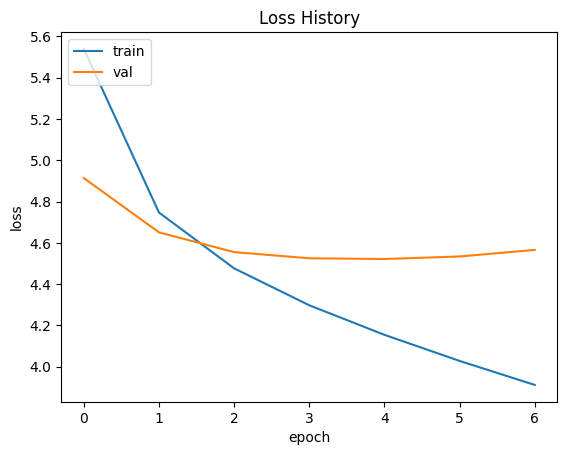

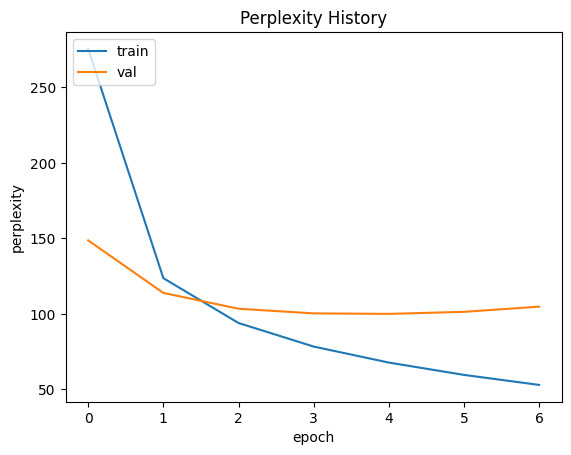

In [13]:
if history is not None:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss History')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['perplexity'])
    plt.plot(history.history['val_perplexity'])
    plt.title('Perplexity History')
    plt.ylabel('perplexity')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Generate Text

In [14]:
def sample_from_top_k(logits, top_k=3):
    logits, indices = ops.top_k(logits, k=top_k, sorted=True)
    indices = np.asarray(indices).astype('int32')
    preds = keras.activations.softmax(ops.expand_dims(logits, 0))[0]
    preds = np.asarray(preds).astype('float32')
    return np.random.choice(indices, p=preds)


def generate_text(model, index_to_word, prompt_tokens, num_tokens, max_num_tokens):
    num_tokens_generated = 0
    tokens_generated = []
    current_tokens = prompt_tokens.copy()
    while num_tokens_generated <= num_tokens:
        pad_len = max_num_tokens - len(current_tokens)
        sample_index = len(current_tokens) - 1
        if pad_len < 0:
            x = current_tokens[:max_num_tokens]
            sample_index = max_num_tokens - 1
        elif pad_len > 0:
            x = current_tokens + [0] * pad_len
        else:
            x = current_tokens
        x = np.array([x])
        model_output = model.predict(x, verbose=0)
        next_token = sample_from_top_k(model_output[0][sample_index], top_k=3)
        tokens_generated.append(next_token)
        current_tokens.append(next_token)
        num_tokens_generated += 1

    result = ' '.join(
        [index_to_word[token_id]
            for token_id in current_tokens + tokens_generated]
    )
    return result

In [15]:
model.load_weights('/content/final.weights.h5')

vocabulary = vectorize_layer.get_vocabulary()

word_to_index = {word: index for index, word in enumerate(vocabulary)}

start_prompt = 'this movie'
prompt_tokens = [word_to_index.get(w, 1) for w in start_prompt.split()]
num_tokens = 40

keras.utils.set_random_seed(SEED)
result = generate_text(model, vocabulary, prompt_tokens, num_tokens, MAX_SEQ_LENGTH)

print(f'generated text:\n{result}\n')

generated text:
this movie is one of the best movies i have ever seen . the plot is so bad , i can 't even believe it was made in the first place . the acting was so terrible . i was very disappointed . is one of the best movies i have ever seen . the plot is so bad , i can 't even believe it was made in the first place . the acting was so terrible . i was very disappointed .

